In [1]:
import pandas as pd, numpy as np, seaborn as sbn
import dask.dataframe as dd
from collections import defaultdict
import re
from pathlib import Path


In [8]:
%matplotlib inline

In [9]:
ddf=dd.read_csv("../search-output/output-*/sioux_faux/sioux_faux-1k*/competition/submissionScores.csv")

In [4]:
def split_range(range_repr):
    """
    Split's out a mathematial range representation into its component bounds.
    
    Exclusive ('(',')') bounds will have the left and/or right bounds properly
    augmented with +1 and -1, respectively. Inclusive bounds ('[',']') will remain
    as written.
    
    Parameters
    ----------
    range_repr : str
        A formatted representation of the range with exclusive and inclusive
        bounds represented as '(',')' and/or '[',']', respectively, for example,
        the range "(300:500]" represents all numbers between 300 (exclusive) and 500
        (inclusive).
    
    Returns
    -------
    str
        The input range representation as pair of integers with the ':' remaining to permit
        easy splitting with the series `str.split` function when the `expand` argument is `True`.
    
    Examples
    --------
    >>> split_range("(47000:202000]")
    '47001:202000'
    >>> split_range("(47000:202000]")
    '155000:176000'
    
    """
    l,r = range_repr.strip("(),[]").split(":")
    l = int(l) + 1 if range_repr[0] is '(' else int(l) + 0
    r = int(r) - 1 if range_repr[-1] is ')' else int(r) + 0
    return "{}:{}".format(l,r)


In [5]:
import glob

common="../search-output/"
output_dirs = glob.glob(common+"output-*/sioux_faux/sioux_faux-1k*/competition/")


In [6]:

sub_score_dfs = []
all_input_dfs = []
SUBMISSION_INPUTS_DIR_NAME = "submission-inputs/"
SUB_SCORE_NAME = "submissionScores.csv"
input_names = ("FrequencyAdjustment","ModeSubsidies","PtFares","VehicleFleetMix")

for output_dir in output_dirs:
    # Load sub_score_dfs
    sub_score_file = output_dir + SUB_SCORE_NAME
    if not Path(sub_score_file).is_file():
        continue
    score_df = pd.read_csv(sub_score_file,index_col="Component Name")
    output_key = re.findall("^.*/output-([\w|\d]*)/.*$",output_dir)[0]
    score_df["output_key"] = output_key
    sub_score_dfs.append(score_df[["Weighted Score","output_key"]])
    input_set = []
    for input_name in input_names:
        input_file = output_dir + SUBMISSION_INPUTS_DIR_NAME +"/"+ input_name+".csv"
        input_df = pd.read_csv(input_file)
        input_set.append(input_df)
    inputs_df = pd.concat(input_set,axis=1,keys = input_names)
    inputs_df["output_key"] = output_key
    all_input_dfs.append(inputs_df)

In [112]:
input_db = pd.concat(all_input_dfs).set_index("output_key")


In [113]:
trip_id_factors = pd.factorize(input_db.loc[:,("FrequencyAdjustment","trip_id")])
input_db.loc[:,("FrequencyAdjustment","trip_id")]=trip_id_factors[0]

mode_factors = pd.factorize(input_db.loc[:,("ModeSubsidies", "mode")])
input_db.loc[:,("ModeSubsidies","mode")]=mode_factors[0]

a,b = pd.factorize(list(set(input_db.loc[:,("PtFares", "routeId")].values).union(set(input_db.loc[:,("VehicleFleetMix", "routeId")]))))
mapping = dict(zip(b,a))
input_db.loc[:,("PtFares", "routeId")]=input_db.loc[:,("PtFares", "routeId")].apply(lambda x: mapping[x])
input_db.loc[:,("VehicleFleetMix", "routeId")] = input_db.loc[:,("VehicleFleetMix", "routeId")].apply(lambda x: mapping[x])

vehicle_type_factors = pd.factorize(input_db.loc[:,("VehicleFleetMix", "vehicleTypeId")])
input_db.loc[:,("VehicleFleetMix", "vehicleTypeId")] = vehicle_type_factors[0]

In [114]:
def expand_range_column(in_df,input_name):
    field = input_name[1]
    in_series = in_df.loc[:,input_name]
    in_df = in_series.apply(split_range).str.split(":",expand=True)
    in_df.columns = pd.MultiIndex.from_product([[input_name[0]],["{}_low".format(field),"{}_high".format(field)]])
#     in_df
    return in_df


In [119]:
def split_input_range(input_df,input_type,input_fields):
    tmp_res = []
    for input_field in input_fields:
        split_input_field=expand_range_column(input_df,(input_type,input_field))
        input_df.drop((input_type,input_field),axis=1,inplace=True)
        tmp_res.append(split_input_field)
    input_subset = input_df.loc[:,[input_type]]
    tmp_res.append(input_subset)
    input_type_df = pd.concat(tmp_res,axis=1)
    return pd.concat([input_df.drop(input_type,axis=1),input_type_df],axis=1)

- Split out ranges and explode to new columns

In [121]:
input_type = "ModeSubsidies"
input_fields = ["income","age"]

input_db = split_input_range(input_db.copy(),input_type,input_fields)

In [123]:
input_type = "PtFares"
input_fields = ["age"]
input_db = split_input_range(input_db.copy(),input_type,input_fields)

/Users/sfeygi/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3108: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [154]:
scores = pd.concat(sub_score_dfs)
sub_scores = scores.loc["Submission Score"]

In [155]:
sub_scores.columns=pd.MultiIndex.from_product([['a'], sub_scores.columns])

In [156]:
sub_score_df = pd.merge(sub_scores,input_db,how="outer",right_index=True,left_on=[("a","output_key")])

In [157]:
sub_score_df=sub_score_df.set_index(('a','output_key'))
sub_score_df.index.name = 'output_key'

In [303]:
freq_df=pd.merge(sub_scores["a"],input_db["VehicleFleetMix"],how="outer",right_index=True,left_on=[("output_key")])

In [304]:
freq_df

,Weighted Score,output_key,agencyId,routeId,vehicleTypeId
Component Name,,,,,
Submission Score,358.253449,fljuazbb,217,7,0
Submission Score,358.253449,fljuazbb,217,2,0
Submission Score,358.253449,fljuazbb,217,1,1
Submission Score,358.253449,fljuazbb,217,8,2
Submission Score,358.253449,fljuazbb,217,10,2
Submission Score,358.253449,fljuazbb,217,11,1
Submission Score,358.253449,fljuazbb,217,3,3
Submission Score,358.253449,fljuazbb,217,5,1
Submission Score,358.253449,fljuazbb,217,9,3


In [305]:
test_df=freq_df.loc[:,'Weighted Score':].reset_index(drop=True).drop('output_key',axis=1)

In [306]:
test_df["Weighted Score"].describe()

count    1040.000000
mean     1179.355861
std      1450.967800
min         0.000000
25%       271.386123
50%       686.453723
75%      1530.935567
max      7697.940789
Name: Weighted Score, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c3d9bfef0>,
      dtype=object)

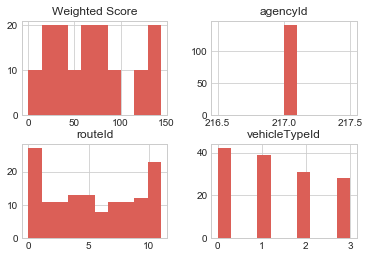

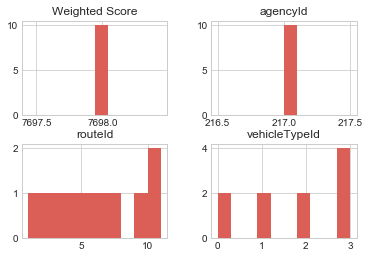

In [310]:
test_df[test_df["Weighted Score"]<150].hist()
test_df[test_df["Weighted Score"]>7030].hist()

-25.328436022934504

In [308]:
test_df[test_df["Weighted Score"]>1571]

,Weighted Score,agencyId,routeId,vehicleTypeId
60,2442.538930,217,10,3
61,2442.538930,217,6,2
62,2442.538930,217,0,1
63,2442.538930,217,9,2
64,2442.538930,217,3,2
65,2442.538930,217,5,1
66,2442.538930,217,11,3
67,2442.538930,217,1,3
68,2442.538930,217,4,1
69,2442.538930,217,2,0
